In [3]:
import importlib

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import odeint
from scipy.stats import norm

import GCExitPathwayModel as GCEPM
import CD40Subnetwork as CDSUB

importlib.reload(GCEPM)
importlib.reload(CDSUB)

<module 'CD40Subnetwork' from 'd:\\UvA\\bioinformatics\\cell-differentiation-in-affinity-maturation-of-the-germinal-center\\CD40Subnetwork.py'>

# 1) Signal modelling in basic GC-Exit Pathway Model

Since the exact BCR and CD40 signals modelling is relatively unclear in the original paper by Martinez, we had to reverse-engineer this part of the model in order to obtain similar results. To not repeat the same mistake, we dedicate this section for precise explanation on the signal modelling considered in this work.

To summarize information in the Martinez paper, the full ODE model is described by five equations, of which three $(\text{eq.} \; 1,2,3)$ describe the change in expression of BLIMP1, BCL6 and IRF4 ($p,b$ and $r$, respectively) and the remaining two equations $(\text{eq.} \; 4,5)$ describe the strength of $\text{BCR}$ and $\text{CD40}$ signals within the centrocyte, after their repression by BCL6.

$$
\begin{equation}
\frac{dp}{dt} = \mu_p + \sigma_p \frac{k_b^2}{k_b^2 + b^2} + \sigma_p \frac{r^2}{k_r^2 + r^2} - \lambda_p p \tag{$1$} 
\end{equation}
$$

$$
\begin{equation}
\frac{db}{dt} = \mu_b + \sigma_b \frac{k_p^2}{k_p^2 + p^2} \cdot \frac{k_b^2}{k_b^2 + b^2} \cdot \frac{k_r^2}{k_r^2 + r^2} - (\lambda_b + \text{BCR}) b \tag{$2$} 
\end{equation}
$$

$$
\begin{equation}
\frac{dr}{dt} = \mu_r + \sigma_r \frac{r^2}{k_r^2 + r^2} + \text{CD40} - \lambda_r r \tag{$3$} 
\end{equation}
$$

$$
\begin{equation}
\text{BCR} = bcr_{0} \frac{k_b^2}{k_b^2 + b^2} \tag{$4$} 
\end{equation}
$$

$$
\begin{equation}
\text{CD40} = cd_{0} \frac{k_b^2}{k_b^2 + b^2} \tag{$5$} 
\end{equation}
$$

Given the (scarce) information in the Martinez paper, we know that these signals should be modelled with a bell shape curve. Whether the bell shape is used before the BCL6 repression $(bcr_0, cd_0)$ or after the repression $(\text{BCR},  \text{CD40})$ is unclear. In this work, we assume that the signal has a bell shape before the repression and, more generally, $bcr_0, cd_0$ terms are not constant and define the strength, shape and the period in time where the signal is expressed $(\text{eq.} \; 6,7)$. Qualitatively, this assumption can be explained by considering $bcr_0$ and $cd_0$ as input signals for in vitro experiments. This approach to $bcr_0$ and $cd_0$ represents the strength of signal delivered into the centrocyte in an in vitro experiment and allows for more feasible verification of simulated results in laboratory conditions.

$$
\begin{equation}
bcr_{0} = bcr(t) \tag{$6$} 
\end{equation}
$$

$$
\begin{equation}
cd_{0} = cd(t) \tag{$7$} 
\end{equation}
$$

We considered two standard ways of modelling $bcr_0, cd_0$ as time-dependent signals $s(t)$: rectangular signal $(\text{eq.} \; 8)$ and bell-curve signal $(\text{eq.} \; 9)$ where:

* $A$ is the maximal signal amplitude
* $t_{start}$ is the time at which the signal starts
* $t_{end}$ is the time at which the signal ends
* $t_{peak}$ is the time at which the signal peaks
* $\sigma_{t}$ is the signal width

$$
\begin{equation}
s_{rectangular}(t) = A ( H(t - t_{start}) - H(t - t_{end}) ) \tag{$8$} 
\end{equation}
$$

$$
\begin{equation}
s_{normal}(t) =  A \big( \frac{1}{\sigma_{t} \sqrt{2 \pi}} \exp{(-\frac{1}{2} (\frac{t - t_{peak}}{\sigma_t}))^2} \big) \tag{$9$} 
\end{equation}
$$

In the plots below we present examples of qualitatively similar model dynamics with both of these signal types, with their corresponding values of $bcr_0, cd_0, \text{BCR}, \text{CD40}$ plotted over time. For the remainder of this work, we will only use bell-curve signal.

In [4]:
# "Default" model parameters as given in table S1 of the Martinez paper
mu_p = 1e-6
mu_b = 2
mu_r = 0.1

sigma_p = 9
sigma_b = 100
sigma_r = 2.6

k_p = 1
k_b = 1
k_r = 1

lam_p = 1
lam_b = 1
lam_r = 1

In [5]:
mu = np.array([mu_p, mu_b, mu_r])
sigma = np.array([sigma_p, sigma_b, sigma_r])
k = np.array([k_p, k_b, k_r])
lam = np.array([lam_p, lam_b, lam_r])

In [6]:
# Time steps
t = np.linspace(0, 100, 10000)

# Initial conditions
p0 = 0.0  # BLIMP1
b0 = 0.0  # BCL6
r0 = 0.0  # IRF4

y0 = np.array([p0, b0, r0])

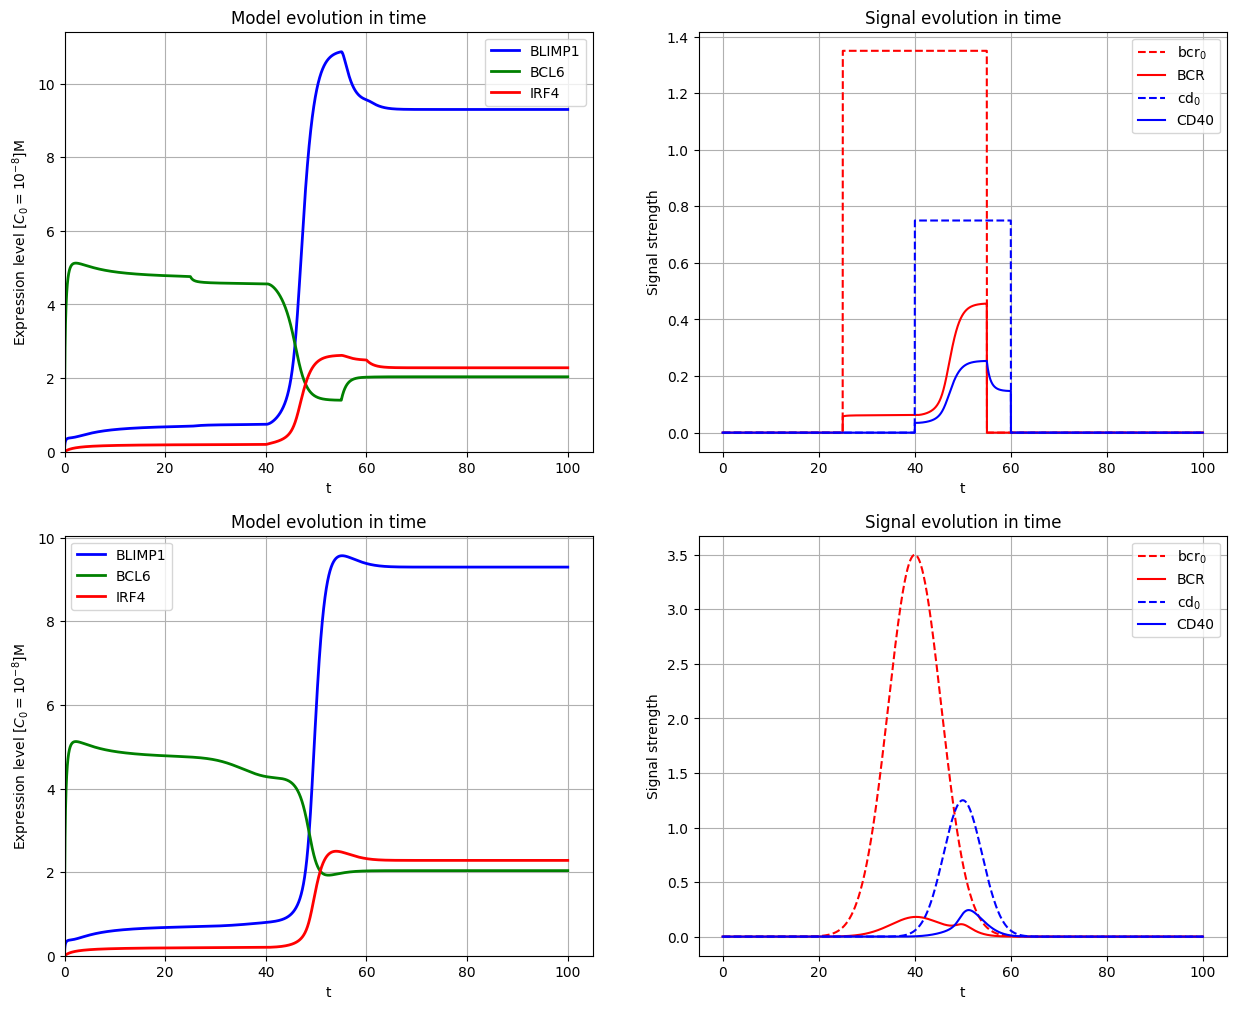

In [7]:
# Solutions and plotting
fig, ax = plt.subplots(2,2,figsize=(15,12))

# Heaviside signal
bcrt = lambda t : GCEPM.rectangle_signal(t, strength=1.35, tstart=25, tend=55)
cdt = lambda t : GCEPM.rectangle_signal(t, strength=0.75, tstart=40, tend=60)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)

GCEPM.plot_model(ax[0,0], t, sol)
GCEPM.plot_singals(ax[0,1], t, sol, k_b, bcrt, cdt)

# Bell curve signal
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=3.5, loc=40, scale=5.5)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=1.25, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)

GCEPM.plot_model(ax[1,0], t, sol)
GCEPM.plot_singals(ax[1,1], t, sol, k_b, bcrt, cdt)

# 2) Bistability in the BCR subnetwork

In the BCR subnetwork, dynamical equations of the baseline model are reduced to:

$$
\begin{align}
\text{BLIMP1}: \;\;\; & \frac{dp}{dt} = \mu_p + \sigma_p \frac{k_b^2}{k_b^2 + b^2} - \lambda_p p \\
\text{BCL6}: \;\;\; & \frac{db}{dt} = \mu_{b} + \sigma_{b} \frac{k_p^2}{k_p^2 + p^2} \cdot \frac{k_b^2}{k_b^2 + b^2} - (\lambda_b + bcr_0 \frac{k_b^2}{k_b^2 + b^2}) b \\
\end{align}
$$

Setting both $\frac{dp}{dt}, \frac{db}{dt}$ to $0$ and rewriting $p$ (BLIMP1) in terms of $b$ (BCL6) yields nullcline formulas as below. We substitute a constant value for $bcr_0$.

$$
\begin{align}
p(b) \mid_{\frac{dp}{dt} = 0} &= \frac{\mu_p + \sigma_p \frac{k_b^2}{k_b^2 + b^2}}{\lambda_p} \\
p(b) \mid_{\frac{db}{dt} = 0} &= \sqrt{\frac{\sigma_b k_p^2 k_b^2}{(k_b^2 + b^2) \left[ (\lambda_b + bcr_0 \frac{k_b^2}{k_b^2 + b^2}) b - \mu_b\right]} - k_p^2} = \\
\end{align}
$$

In [8]:
# BLIMP1 nullcline as given in the equation above
def dpdt_nullcline(b, kb, mp, sp, lp):
    return (mp + sp * ((kb**2) / (kb**2 + b**2))) / lp

# BCL6 nullcline as given in the equation above
def dbdt_nullcline(b,  kb, kp, mb, sb, lb, bcr0):
    BCR = bcr0 * ((kb**2) / (kb**2 + b**2))
    return np.sqrt((sb * kp**2 * kb**2) / ((kb**2 + b**2)*((lb + BCR)*b - mb)) - kp**2)

In [9]:
plt.rcParams.update({'font.size': 18})

C:\Users\User23718901\AppData\Local\Temp\ipykernel_24804\2921402822.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((sb * kp**2 * kb**2) / ((kb**2 + b**2)*((lb + BCR)*b - mb)) - kp**2)


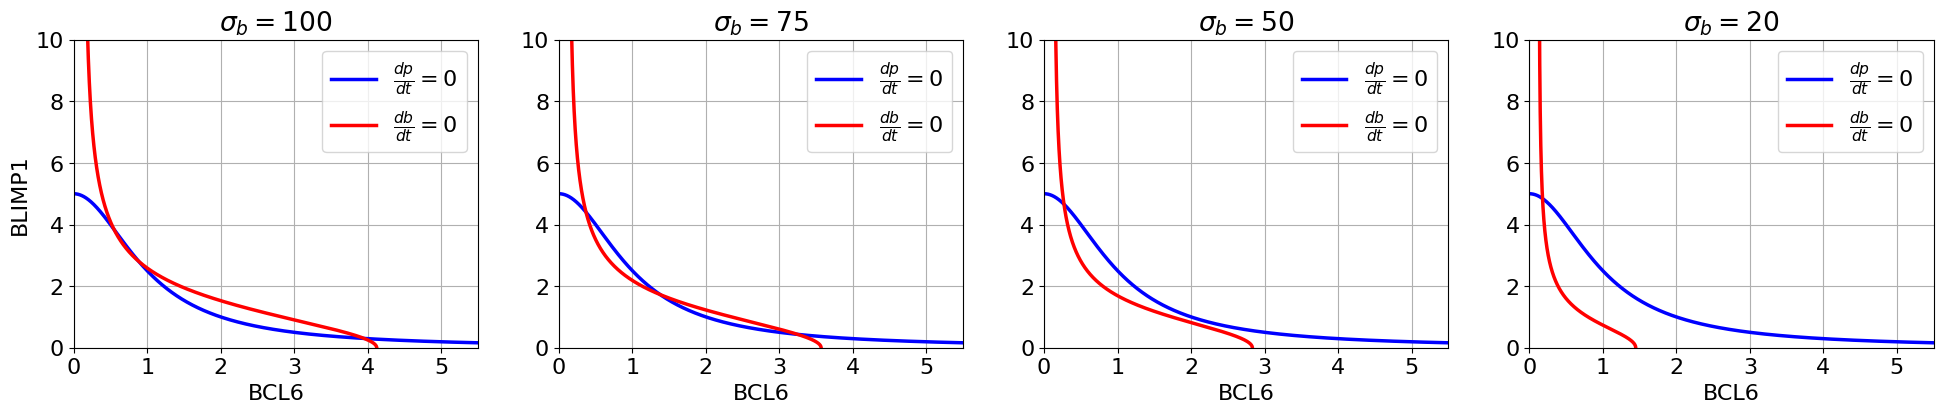

In [24]:
bs = np.linspace(0, 5.5, 10000)

# "Default" model parameters as given in table S1 of the Martinez paper
mu_p = 1e-6
mu_b = 2

sigma_p = 5

k_p = 1
k_b = 1

lam_p = 1
lam_b = 1

# The paper claims that the system becomes bistable under the condition that sigma_b / lambda_b = 20.
# This seems not to be the case and we verify it by plotting nullclines for different values of sigma_b while keeping lambda_b constant.
sigma_bs = [100, 75, 50, 20]

# Plotting
fig, axes = plt.subplots(1,4,figsize=(24,4))
axes[0].set_ylabel("BLIMP1")

for sigma_b, ax in zip(sigma_bs, axes.flatten()):
    dpdt = dpdt_nullcline(bs, k_b, mu_p, sigma_p, lam_p)
    dbdt = dbdt_nullcline(bs, k_b, k_p, mu_b, sigma_b, lam_b, 15)

    ax.plot(bs, dpdt, color="blue", label=r"$\frac{dp}{dt} = 0$", lw=2.5)
    ax.plot(bs, dbdt, color="red", label=r"$\frac{db}{dt} = 0$", lw=2.5)

    ax.set_xlabel("BCL6")
    ax.set_title(r"$\sigma_b = $" + f"{sigma_b}")

    ax.set_ylim(0, 10)
    ax.set_xlim(0, 5.5)

    ax.grid()
    ax.legend()

plt.show()

In [11]:
from scipy.optimize import fsolve

In [12]:
# BLIMP1 nullcline as given in the equation above
def dpdt_nullcline(b, kb, mp, sp, lp):
    return (mp + sp * ((kb**2) / (kb**2 + b**2))) / lp

# BCL6 nullcline as given in the equation above
def dbdt_nullcline(b,  kb, kp, mb, sb, lb, bcr0):
    BCR = bcr0 * ((kb**2) / (kb**2 + b**2))
    return np.sqrt((sb * kp**2 * kb**2) / ((kb**2 + b**2)*((lb + BCR)*b - mb)) - kp**2)

In [13]:
def find_roots(func, xmin, xmax, dx):
    roots = np.array([])
    xs = np.arange(start=xmin, stop=xmax, step=dx)
    for x in xs:
        r = fsolve(func, [x])
        if np.isclose(func(r), 0) and not np.count_nonzero(np.isclose(roots, r)):
            roots = np.append(roots, r)
    return roots

In [14]:
# "Default" model parameters as given in table S1 of the Martinez paper
mu_p = 1e-6
mu_b = 2
mu_r = 0.1

sigma_p = 9
sigma_b = 100
sigma_r = 2.6

k_p = 1
k_b = 1
k_r = 1

lam_p = 1
lam_b = 1
lam_r = 1

In [15]:
plt.rcParams.update({'font.size': 18})

C:\Users\User23718901\AppData\Local\Temp\ipykernel_24804\2921402822.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((sb * kp**2 * kb**2) / ((kb**2 + b**2)*((lb + BCR)*b - mb)) - kp**2)
C:\Users\User23718901\AppData\Local\Temp\ipykernel_24804\1133576642.py:5: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  r = fsolve(func, [x])
C:\Users\User23718901\AppData\Local\Temp\ipykernel_24804\2921402822.py:8: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt((sb * kp**2 * kb**2) / ((kb**2 + b**2)*((lb + BCR)*b - mb)) - kp**2)
C:\Users\User23718901\AppData\Local\Temp\ipykernel_24804\1133576642.py:5: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  r = fsolve(func, [x])


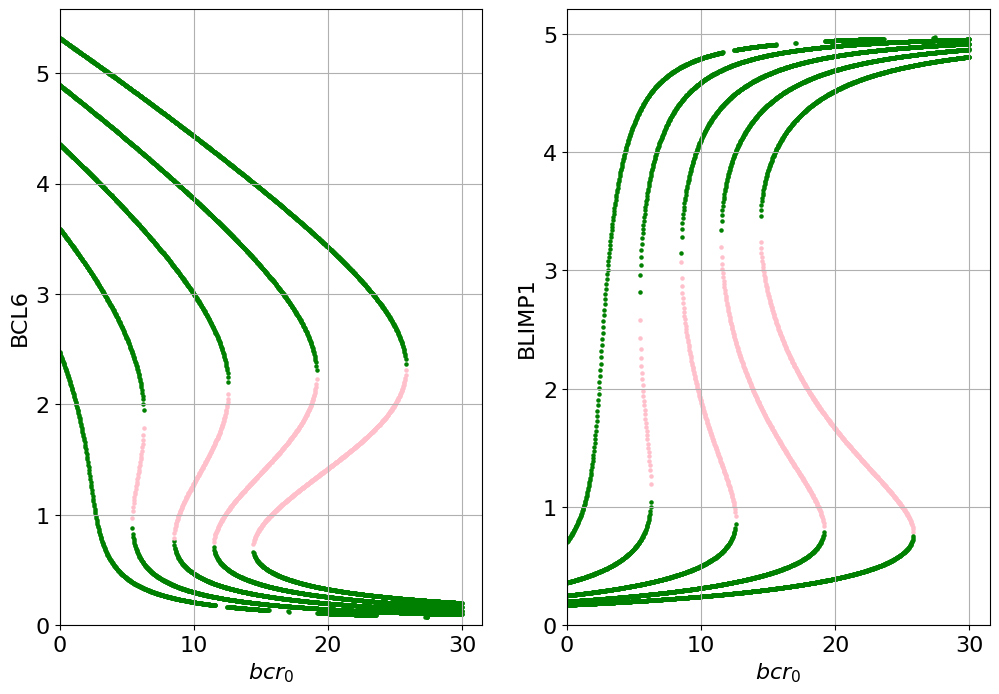

In [36]:
# NOTE: this step takes a while (~ 6 minutes on my machine), as finding all function roots is not an easy task

bmin, bmax, bstep = 0, 5, 0.05
bcrs = np.linspace(0, 30, 1000)

sigma_bs = [5, 25, 50, 75, 100]

fig, ax = plt.subplots(1,2,figsize=(12,8))

for sigma_b in sigma_bs:
    for bcr0 in bcrs:
        dpdt0 = lambda b : dpdt_nullcline(b, k_b, mu_p, sigma_p, lam_p)
        dbdt0 = lambda b : dbdt_nullcline(b, k_b, k_p, mu_b, sigma_b, lam_b, bcr0)
        rootfunc = lambda b : dpdt0(b) - dbdt0(b)

        b_roots = find_roots(rootfunc, bmin, bmax, bstep)
        b_roots = sorted(b_roots)
        
        for (i, b_root) in enumerate(b_roots):
            p_root = dpdt0(b_root)
            if (i == 1 and len(b_roots) == 3):
                ax[0].scatter(bcr0, b_root, color="pink", s=5)
                ax[1].scatter(bcr0, p_root, color="pink", s=5)
            else:
                ax[0].scatter(bcr0, b_root, color="green", s=5)
                ax[1].scatter(bcr0, p_root, color="green", s=5)

ax[0].set_xlim(0,)
ax[0].set_ylim(0,)
ax[0].set_xlabel(r"$bcr_0$")
ax[0].set_ylabel("BCL6")
ax[0].grid()

ax[1].set_xlim(0,)
ax[1].set_ylim(0,)
ax[1].set_xlabel(r"$bcr_0$")
ax[1].set_ylabel("BLIMP1")
ax[1].grid()

plt.show()

# 3) Bistability in CD40 subnetwork

In [ ]:
# Time steps
t = np.linspace(0, 100, 10000)

# Initial condition
r0 = 0.0

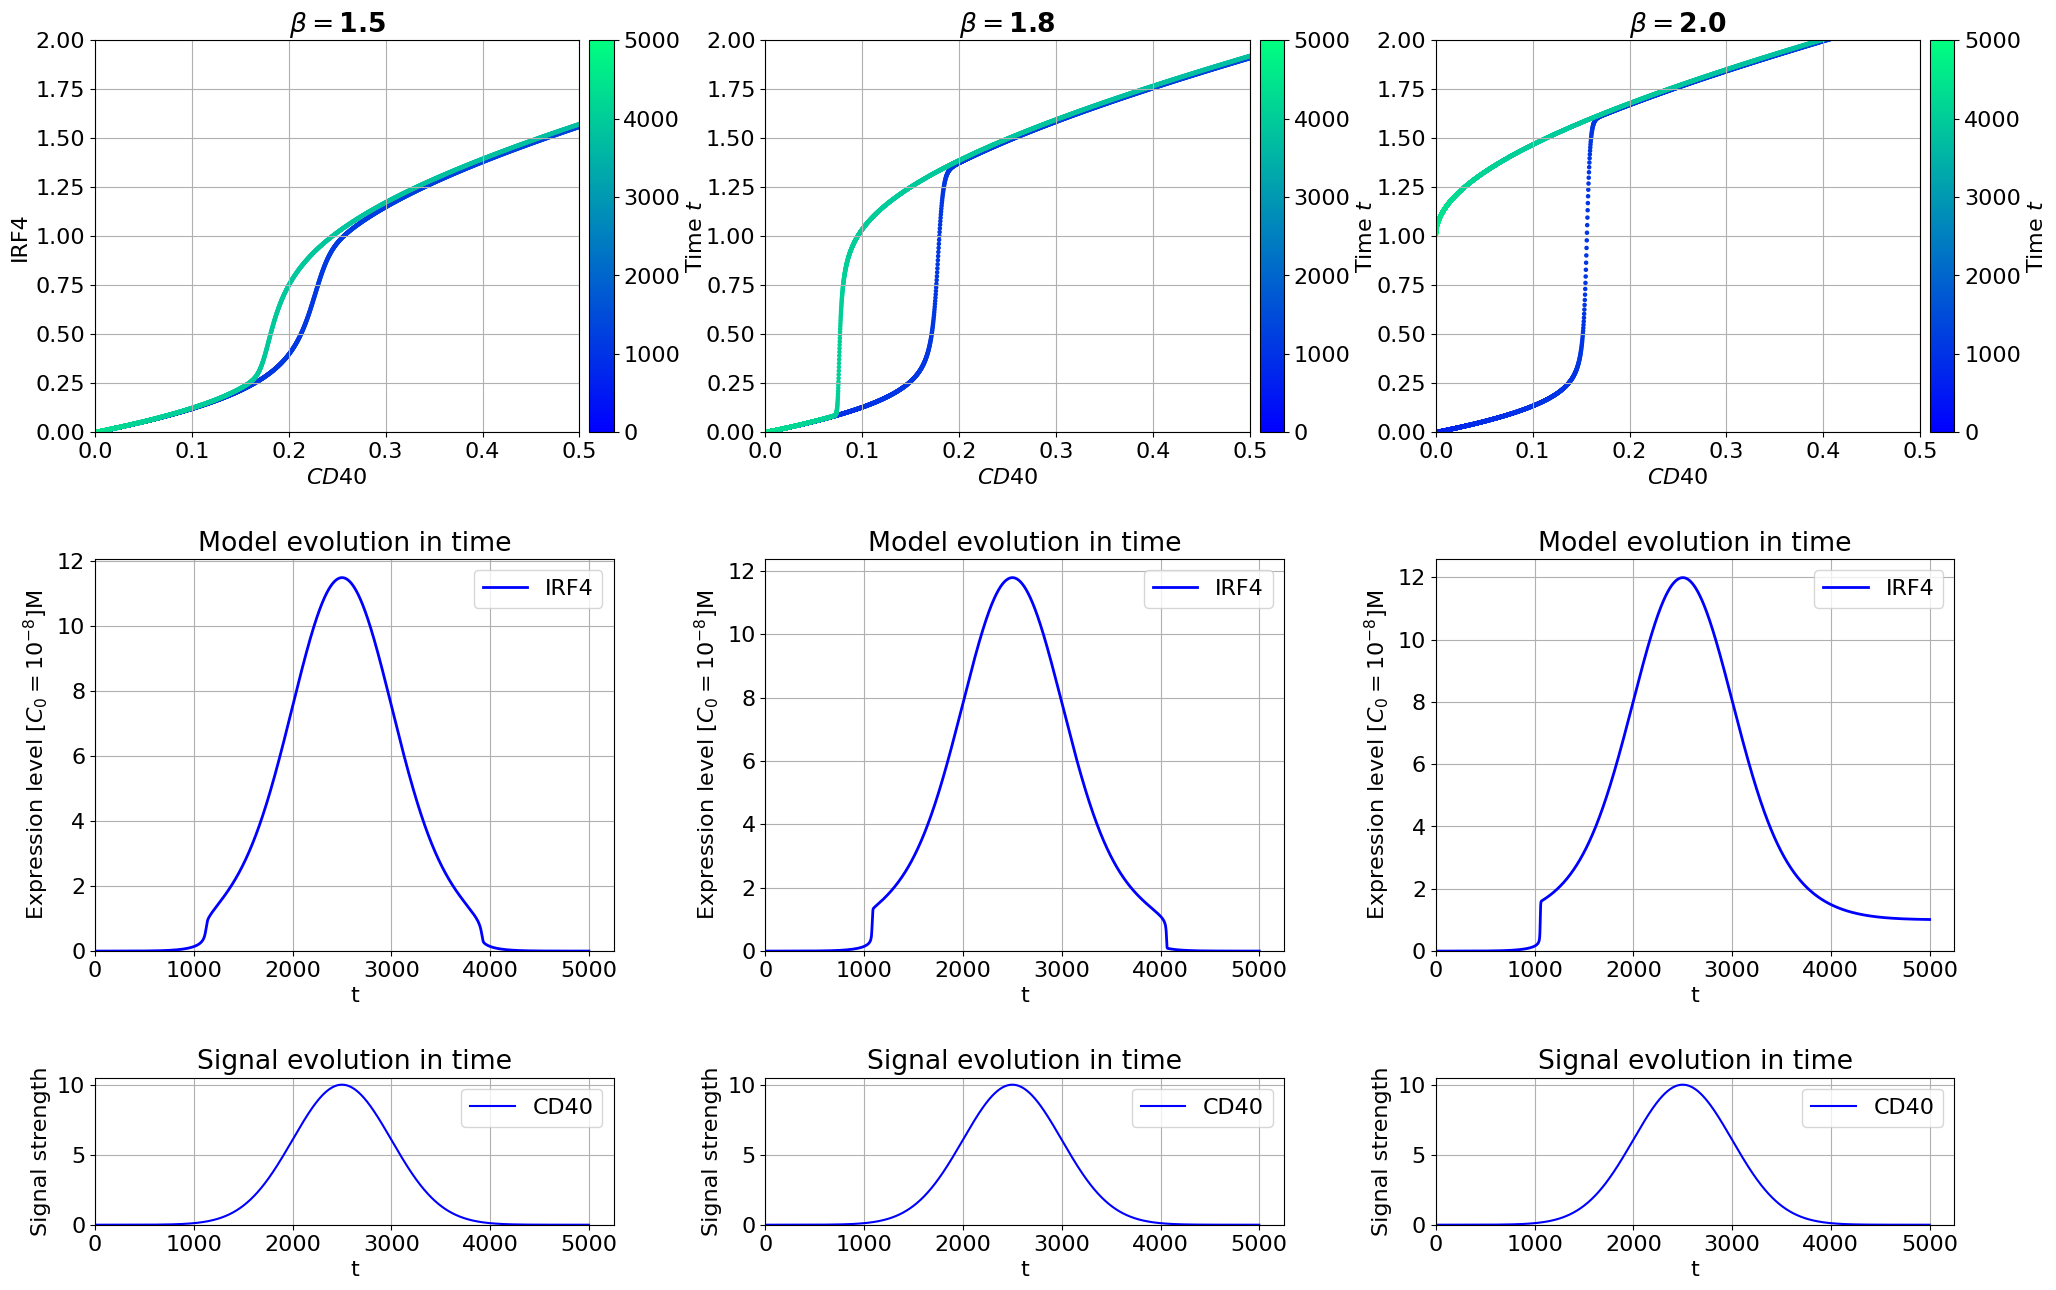

In [ ]:
plt.rcParams.update({'font.size': 16})

# Solutions and plotting
fig, ax = plt.subplots(3,3,figsize=(21,14),height_ratios=[2,2,0.75])
fig.tight_layout(pad=4.0)

# --- CASE 1: Beta = 1.5 ---
mu_r = 0.00
sigma_r = 1.5
k_r = 1
lam_r = 1

cd0_strength = 10
t = np.linspace(0, 5000, 20000)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=cd0_strength, loc=2500, scale=500)

sol = CDSUB.solve_model(r0, t, k_r, sigma_r, mu_r, lam_r, cdt)
r = sol[:, 0]

cd0 = cdt(t)
# CD40 = cd0 * ((k_b**2) / (k_b**2 + b**2))

# Beta calculation
beta = (mu_r + 0 + sigma_r) / (lam_r * k_r)

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,0].scatter(cd0, r, s=5, c=t, cmap="winter")
ax[0,0].grid()
ax[0,0].set_xlabel(r"$CD40$")
ax[0,0].set_ylabel("IRF4")
ax[0,0].set_xlim(0,0.5)
ax[0,0].set_ylim(0,2.0)
ax[0,0].set_title(r"$\beta = $" + f"{beta}", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# # Model dynamics
CDSUB.plot_model(ax[1,0], t, sol)

# Signal plot
CDSUB.plot_signals(ax[2,0], t, cdt)
ax[2,0].set_ylim(0,)
ax[2,0].set_xlim(0,)

# --- CASE 2: Beta = 1.8 ---
mu_r = 0.00
sigma_r = 1.8
k_r = 1
lam_r = 1

sol = CDSUB.solve_model(r0, t, k_r, sigma_r, mu_r, lam_r, cdt)
r = sol[:, 0]

cd0 = cdt(t)
# CD40 = cd0 * ((k_b**2) / (k_b**2 + b**2))

# Beta calculation
beta = (mu_r + 0 + sigma_r) / (lam_r * k_r)

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,1].scatter(cd0, r, s=5, c=t, cmap="winter")
ax[0,1].grid()
ax[0,1].set_xlabel(r"$CD40$")
# ax[0,1].set_ylabel("IRF4")
ax[0,1].set_xlim(0,0.5)
ax[0,1].set_ylim(0,2.0)
ax[0,1].set_title(r"$\beta = $" + f"{beta}", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# # Model dynamics
CDSUB.plot_model(ax[1,1], t, sol)

# Signal plot
CDSUB.plot_signals(ax[2,1], t, cdt)
ax[2,1].set_ylim(0,)
ax[2,1].set_xlim(0,)


# --- CASE 3: Beta = 2 ---
mu_r = 0.00
sigma_r = 2.0
k_r = 1
lam_r = 1

sol = CDSUB.solve_model(r0, t, k_r, sigma_r, mu_r, lam_r, cdt)
r = sol[:, 0]

cd0 = cdt(t)
# CD40 = cd0 * ((k_b**2) / (k_b**2 + b**2))

# Beta calculation
beta = (mu_r + 0 + sigma_r) / (lam_r * k_r)

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,2].scatter(cd0, r, s=5, c=t, cmap="winter")
ax[0,2].grid()
ax[0,2].set_xlabel(r"$CD40$")
# ax[0,2].set_ylabel("IRF4")
ax[0,2].set_xlim(0,0.5)
ax[0,2].set_ylim(0,2.0)
ax[0,2].set_title(r"$\beta = $" + f"{beta}", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# # Model dynamics
CDSUB.plot_model(ax[1,2], t, sol)

# Signal plot
CDSUB.plot_signals(ax[2,2], t, cdt)
ax[2,2].set_ylim(0,)
ax[2,2].set_xlim(0,)

plt.show()

# 4) (Ir)reversibility of changes in gene expression levels due to BCR-CD40 cosignalling

In [37]:
# "Default" model parameters as given in table S1 of the Martinez paper
mu_p = 1e-6
mu_b = 2
mu_r = 0.1

sigma_p = 9
sigma_b = 100
sigma_r = 2.6

k_p = 1
k_b = 1
k_r = 1

lam_p = 1
lam_b = 1
lam_r = 1

In [38]:
mu = np.array([mu_p, mu_b, mu_r])
sigma = np.array([sigma_p, sigma_b, sigma_r])
k = np.array([k_p, k_b, k_r])
lam = np.array([lam_p, lam_b, lam_r])

In [39]:
# Time steps
t = np.linspace(0, 100, 10000)

# Initial conditions
p0 = 0.0  # BLIMP1
b0 = 0.0  # BCL6
r0 = 0.0  # IRF4

y0 = np.array([p0, b0, r0])

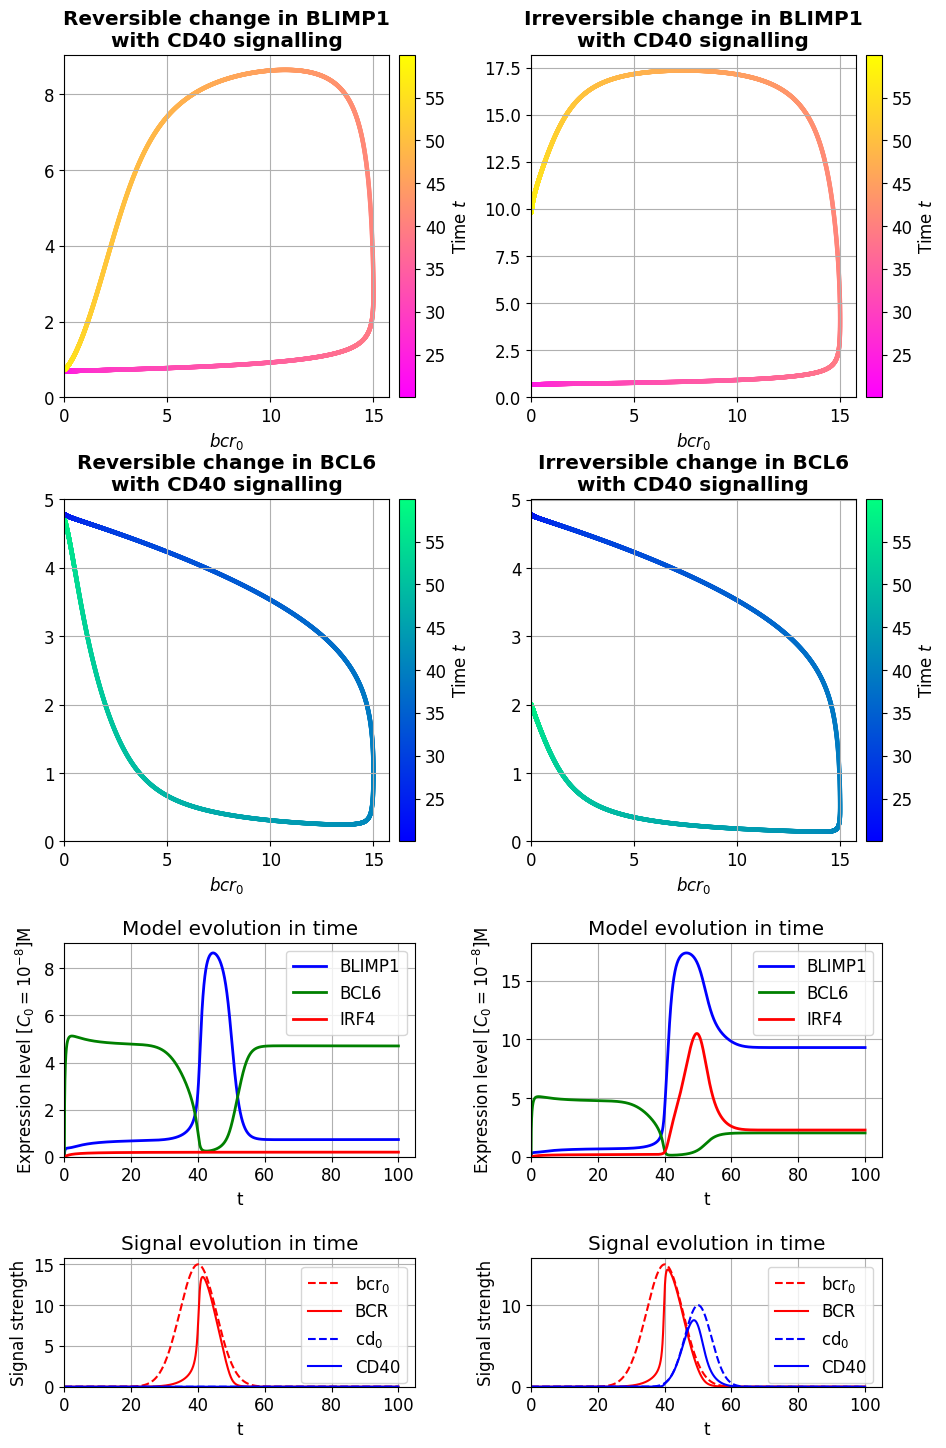

In [80]:
plt.rcParams.update({'font.size': 12})

# Solutions and plotting
fig, ax = plt.subplots(4,2,figsize=(10,15),height_ratios=[2.0,2.0,1.25,0.75])
fig.tight_layout(pad=4.0)

# --- Case 1: No CD40 signalling, reversible behaviour ---
t = np.linspace(0, 100, 10000)
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=15, loc=40, scale=5.5)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=0, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)
p, b = sol[:,0], sol[:, 1]
bcr0 = bcrt(t)
BCR = bcr0 * ((k_b**2) / (k_b**2 + b**2))

# PLot BLIMP1
im = ax[0,0].scatter(bcr0[2000:-4000], p[2000:-4000], s=5, c=t[2000:-4000], cmap="spring")
ax[0,0].set_xlabel(r"$bcr_0$")
ax[0,0].set_title("Reversible change in BLIMP1\nwith CD40 signalling", fontweight="bold")
ax[0,0].grid()

divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# PLot BCL6
im = ax[1,0].scatter(bcr0[2000:-4000], b[2000:-4000], s=5, c=t[2000:-4000], cmap="winter")
ax[1,0].set_xlabel(r"$bcr_0$")
ax[1,0].set_title("Reversible change in BCL6\nwith CD40 signalling", fontweight="bold")
ax[1,0].grid()

divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# Model dynamics
GCEPM.plot_model(ax[2,0], t, sol)

# Signal plot
GCEPM.plot_singals(ax[3,0], t, sol, k_b, bcrt, cdt)
ax[3,0].set_yticks([0,5,10,15])

# --- Case 2: With CD40 signalling, irreversible behaviour ---
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=15, loc=40, scale=5.5)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=10, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)
p, b = sol[:,0], sol[:, 1]
bcr0 = bcrt(t)
BCR = bcr0 * ((k_b**2) / (k_b**2 + b**2))

# PLot BLIMP1
im = ax[0,1].scatter(bcr0[2000:-4000], p[2000:-4000], s=5, c=t[2000:-4000], cmap="spring")
ax[0,1].set_xlabel(r"$bcr_0$")
ax[0,1].set_title("Irreversible change in BLIMP1\nwith CD40 signalling", fontweight="bold")
ax[0,1].grid()

divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# PLot BCL6
im = ax[1,1].scatter(bcr0[2000:-4000], b[2000:-4000], s=5, c=t[2000:-4000], cmap="winter")
ax[1,1].set_xlabel(r"$bcr_0$")
ax[1,1].set_title("Irreversible change in BCL6\nwith CD40 signalling", fontweight="bold")
ax[1,1].grid()

divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# Model dynamics
GCEPM.plot_model(ax[2,1], t, sol)

# Signal plot
GCEPM.plot_singals(ax[3,1], t, sol, k_b, bcrt, cdt)
ax[2,1].set_yticks([0,5,10,15])

# Apply to all axes
for axis in ax.flatten():
    axis.set_xlim(0,)
    axis.set_ylim(0,)

plt.show()

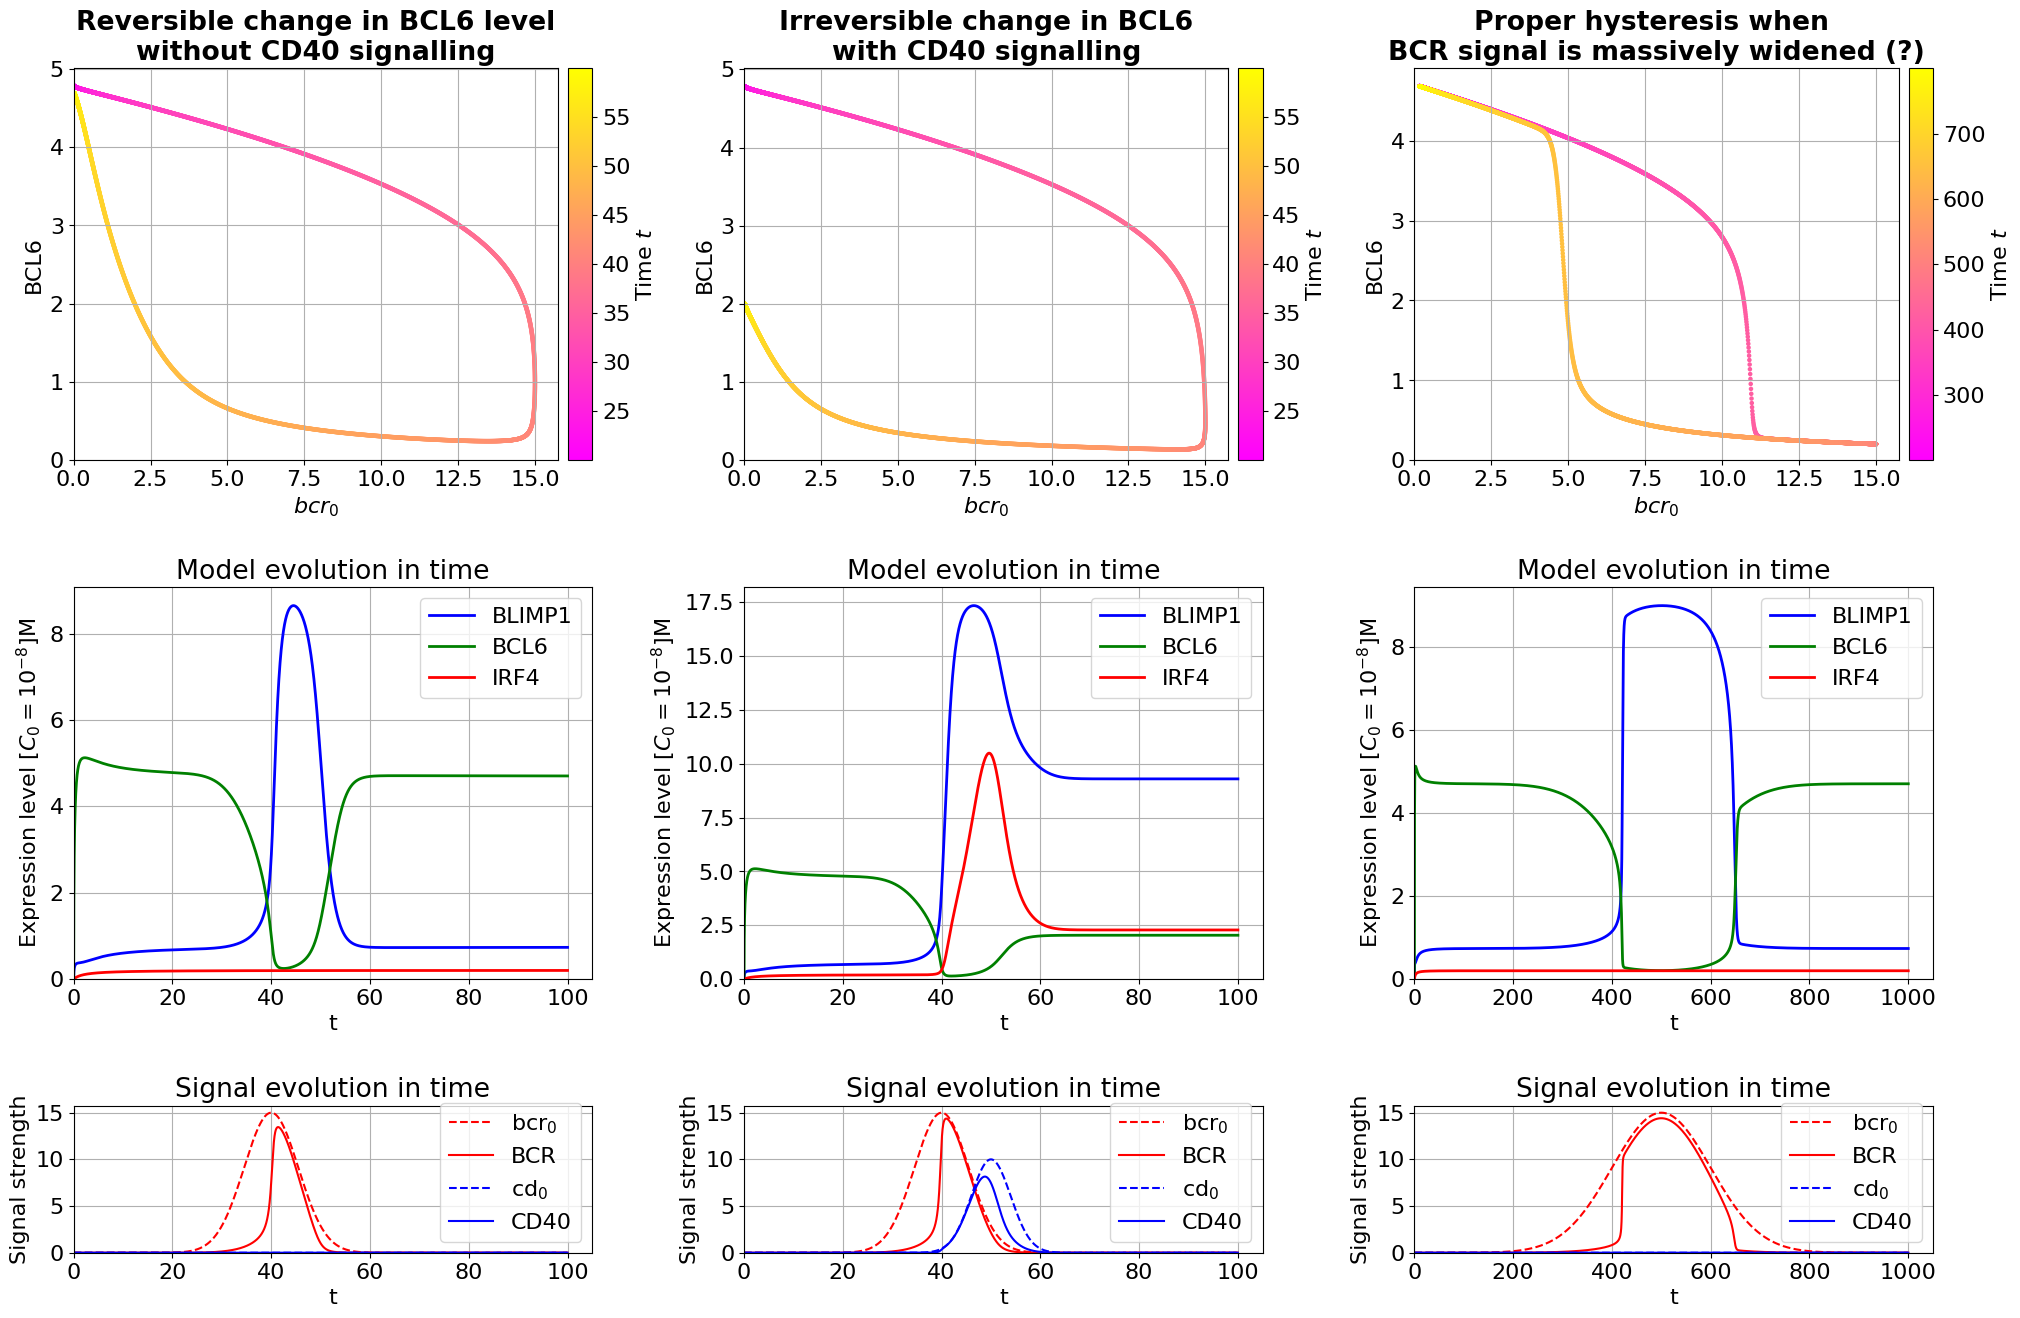

In [21]:
plt.rcParams.update({'font.size': 16})

# Solutions and plotting
fig, ax = plt.subplots(3,3,figsize=(21,14),height_ratios=[2,2,0.75])
fig.tight_layout(pad=4.0)

# --- Case 1: No CD40 signalling, reversible behaviour ---
t = np.linspace(0, 100, 10000)
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=15, loc=40, scale=5.5)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=0, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)
b = sol[:, 1]
bcr0 = bcrt(t)
BCR = bcr0 * ((k_b**2) / (k_b**2 + b**2))

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,0].scatter(bcr0[2000:-4000], b[2000:-4000], s=5, c=t[2000:-4000], cmap="spring")
ax[0,0].grid()
ax[0,0].set_xlabel(r"$bcr_0$")
ax[0,0].set_ylabel("BCL6")
ax[0,0].set_xlim(0,)
ax[0,0].set_ylim(0,)
ax[0,0].set_title("Reversible change in BCL6 level\nwithout CD40 signalling", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# Model dynamics
GCEPM.plot_model(ax[1,0], t, sol)

# Signal plot
GCEPM.plot_singals(ax[2,0], t, sol, k_b, bcrt, cdt)
ax[2,0].set_ylim(0,)
ax[2,0].set_xlim(0,)
ax[2,0].set_yticks([0,5,10,15])

# --- Case 2: With CD40 signalling, irreversible behaviour ---
bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=15, loc=40, scale=5.5)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=10, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)
b = sol[:, 1]
bcr0 = bcrt(t)
BCR = bcr0 * ((k_b**2) / (k_b**2 + b**2))

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,1].scatter(bcr0[2000:-4000], b[2000:-4000], s=5, c=t[2000:-4000], cmap="spring")
ax[0,1].grid()
ax[0,1].set_xlabel(r"$bcr_0$")
ax[0,1].set_ylabel("BCL6")
ax[0,1].set_xlim(0,)
ax[0,1].set_ylim(0,)
ax[0,1].set_title("Irreversible change in BCL6\nwith CD40 signalling", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# Model dynamics
GCEPM.plot_model(ax[1,1], t, sol)

# Signal plot
GCEPM.plot_singals(ax[2,1], t, sol, k_b, bcrt, cdt)
ax[2,1].set_xlim(0,)
ax[2,1].set_ylim(0,)
ax[2,1].set_yticks([0,5,10,15])

# --- Case 3: Proper hysteresis (?) ---
t = np.linspace(0, 1000, 10000)

bcrt = lambda t : GCEPM.bell_curve_signal(t, strength=15, loc=500, scale=100)
cdt = lambda t : GCEPM.bell_curve_signal(t, strength=0, loc=50, scale=4)

sol = GCEPM.solve_model(y0, t, k, sigma, mu, lam, bcrt, cdt)
b = sol[:, 1]
bcr0 = bcrt(t)
BCR = bcr0 * ((k_b**2) / (k_b**2 + b**2))

# BCL6 vs signalling
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.1)
im = ax[0,2].scatter(bcr0[2000:-2000], b[2000:-2000], s=5, c=t[2000:-2000], cmap="spring")
ax[0,2].grid()
ax[0,2].set_xlabel(r"$bcr_0$")
ax[0,2].set_ylabel("BCL6")
ax[0,2].set_xlim(0,)
ax[0,2].set_ylim(0,)
ax[0,2].set_title("Proper hysteresis when \nBCR signal is massively widened (?)", fontweight="bold")
fig.colorbar(im, cax=cax, orientation='vertical', label=r"Time $t$")

# Model dynamics
GCEPM.plot_model(ax[1,2], t, sol)

# Signal plot
GCEPM.plot_singals(ax[2,2], t, sol, k_b, bcrt, cdt)
ax[2,2].set_ylim(0,)
ax[2,2].set_xlim(0,)
ax[2,2].set_yticks([0,5,10,15])

plt.show()

**TODO:** for the hysteresis curve, for a given $bcr_0 (BCR)$, try to find all roots $BCL6$ given the derivatives are $0$ (stable state) and see if you can retrieve hysteresis curve (right column).

The plots above were created for parameters as given in table S1 and show (ir)reversebility of changes in expression level due to cosignalling of BCR and CD40 as well as hysteretic behaviour for both BCL6 and BLIMP1.

* **Rows:**
  * Top row shows genetic expression level changing as the signalling rises and ceases
  * Center row shows corresponding model dynamics
  * Bottom row shows signal levels for both the BCR signalling (red lines) and CD40 signalling (blue lines):
    * Dashed line shows bell curve signal without the BCL6 repression
    * Regular line shows the final signal after taking the repression into account

* **Columns:**
  * Left column shows reversible change in expression level when only BCR signal is active (no cosignalling)
  * Center column shows irreversible change in expression level when both BCR and CD40 signals are active (cosignalling)
  * Right column shows (proper) hysteretic behaviour when the signal as well as the time scale is heavily widened
  
A key change made to the plots to actually show the hysteresis was the $x$-axis. The expression levels are plotted against $bcr_0$ (unrepressed signal) and not against $BCR$ (repressed by BCL6) as the paper suggests. The model is still ran with the repression included. Does this make sense ? Yes, it does. Assuming we want to perform an *in vitro* experiment, we actually *should* be more interested in the $bcr_0$, as this is the value we need for stimulation of BCRs and cell-surface receptors CD40. However, if the signals are indeed repressed by BCL6, we want to include that in the model. It all makes sense !

We observe (left column) that, at first ($t \in [5, 25]$) BCL6 reaches a stable expression level around $5$. Once BCR signalling is activated, BCL6 drops, reaching minimal level at BCR peak and then returning back to the initial level. This is the reversible change - the level went back to its initial value. It is interesting to see how model dynamics relate to the oval-shaped plot showing the reversible change (top-left). The initial drop (pink line) is slow at first, becoming faster with BCR signal strength. The "backward path" (orange-yellow line) shows the same dynamics for the return increase in expression level - it is slow at first (green line at $t \in [40,50]$) and becomes faster when the signal drops. Interestingly, also the BCR signal becomes noticeably assymetrical, losing its characteristic bell shape on its "left" side.

The irreversible change (center column) occurs only when CD40 signalling coexists with BCR. We can see that the oval shaped (top) becomes open. Similarly, the green line (center), after the initial drop, goes back to a different level from the initial one. 